## **Import libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score, make_scorer, recall_score, precision_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## **Upload dataset**

In [2]:
dataset = pd.read_csv('masterTrain.csv')
dataset = dataset.iloc[:, 1:]
# 377010 x 34
# print(dataset.iloc[0:1,:])

In [3]:
from sklearn.model_selection import train_test_split

# Split dataset into users and impostors
num_classes = len(np.unique(dataset['class']))

user = {}
impostor = {}
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for i in range(num_classes):
    user[i] = dataset.loc[dataset['class'] == i]
    impostor[i] = dataset.loc[dataset['class'] != i]
    # scale impostor to the same size as user
    impostor[i] = impostor[i].sample(n=len(user[i]))

    user[i].loc[:, 'class'] = 0
    impostor[i].loc[:, 'class'] = 1

    merged_data = pd.concat([user[i], impostor[i]])
    
    X = merged_data.loc[:, 'mean_x_speed':'numCritPoints']
    y = merged_data['class']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

#### Feature importance

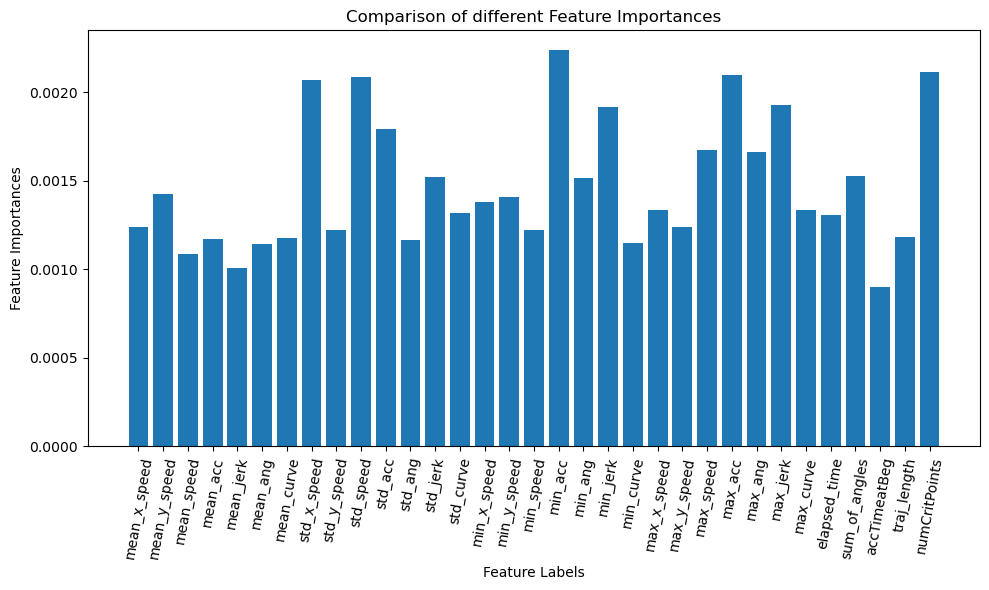

In [6]:
from sklearn.ensemble import ExtraTreesClassifier
extra_tree_forest = ExtraTreesClassifier()

extra_tree_forest.fit(X, y)

feature_importance = extra_tree_forest.feature_importances_

feature_importance_normalized = np.std([tree.feature_importances_ for tree in extra_tree_forest.estimators_], axis = 0)

plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importance_normalized)
plt.xticks(rotation=80)

plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.tight_layout()
plt.show()

# **Random Forest**

### Hyperparameters tuning

#### Randomized Search

In [4]:
from sklearn.ensemble import RandomForestClassifier
import random

best_models_random = []

hyperparams = {
        'n_estimators': [700, 750, 850], #TODO: np.arange(700, 1000, step=50), # tested: 100-500, step=100 -> best 500
        'max_depth': [None] + list(np.arange(50, 100, step=10)), # tested: 10-50, step=10
        'min_samples_split': [1, 2, 4], #TODO: [2, 4, 6, 8, 10],
        'min_samples_leaf': [1], #TODO: [1, 2, 4], 
        'criterion': ['entropy'], #TODO: ['gini','entropy'],
        'max_features': ['sqrt'], #TODO: ['log2', 'sqrt'],
        'bootstrap': [False] #TODO: [True, False]
    }

classes = list(range(num_classes))
random.shuffle(classes)
random_classes = classes[:]

for i in random_classes:
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    rf = RandomForestClassifier()

    random_search = RandomizedSearchCV(rf, hyperparams, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10)
    random_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', random_search.best_params_)
    print('Best score: ', random_search.best_score_)

    best_model = random_search.best_estimator_
    best_models_random.append(best_model)

    predictions = best_model.predict(X_test)

    print(classification_report(y_test, predictions))

C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\

User  0
Best hyperparams: {'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8095807068145797
Mean Squared Error: 0.16066145793825382
R-squared (R2): 0.35735416454918656
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      6591
           1       0.85      0.82      0.84      6592

    accuracy                           0.84     13183
   macro avg       0.84      0.84      0.84     13183
weighted avg       0.84      0.84      0.84     13183



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  8
Best hyperparams: {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8111077694235588
Mean Squared Error: 0.16777608469003127
R-squared (R2): 0.32889565692342404
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      6235
           1       0.85      0.80      0.83      6234

    accuracy                           0.83     12469
   macro avg       0.83      0.83      0.83     12469
weighted avg       0.83      0.83      0.83     12469



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  1
Best hyperparams: {'n_estimators': 850, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8173700787401575
Mean Squared Error: 0.15614764424288233
R-squared (R2): 0.3754094230284707
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      7938
           1       0.86      0.82      0.84      7938

    accuracy                           0.84     15876
   macro avg       0.84      0.84      0.84     15876
weighted avg       0.84      0.84      0.84     15876



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  7
Best hyperparams: {'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8170613737980915
Mean Squared Error: 0.1554597366274327
R-squared (R2): 0.3781610534902692
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      8581
           1       0.86      0.82      0.84      8581

    accuracy                           0.84     17162
   macro avg       0.85      0.84      0.84     17162
weighted avg       0.85      0.84      0.84     17162



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  9
Best hyperparams: {'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8117147192716236
Mean Squared Error: 0.16521000242777373
R-squared (R2): 0.3391599902889051
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      8238
           1       0.85      0.81      0.83      8238

    accuracy                           0.83     16476
   macro avg       0.84      0.83      0.83     16476
weighted avg       0.84      0.83      0.83     16476



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  2
Best hyperparams: {'n_estimators': 850, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8213025917336365
Mean Squared Error: 0.1482793867120954
R-squared (R2): 0.4068824503974877
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      7338
           1       0.86      0.83      0.85      7337

    accuracy                           0.85     14675
   macro avg       0.85      0.85      0.85     14675
weighted avg       0.85      0.85      0.85     14675



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  3
Best hyperparams: {'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8138846135814128
Mean Squared Error: 0.1617490051441328
R-squared (R2): 0.35300397942346884
              precision    recall  f1-score   support

           0       0.81      0.88      0.84     10303
           1       0.87      0.80      0.83     10303

    accuracy                           0.84     20606
   macro avg       0.84      0.84      0.84     20606
weighted avg       0.84      0.84      0.84     20606



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  4
Best hyperparams: {'n_estimators': 850, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8005267108978614
Mean Squared Error: 0.17772842639593908
R-squared (R2): 0.28908629441624367
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      7880
           1       0.86      0.77      0.81      7880

    accuracy                           0.82     15760
   macro avg       0.83      0.82      0.82     15760
weighted avg       0.83      0.82      0.82     15760



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  6
Best hyperparams: {'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.8222169121448213
Mean Squared Error: 0.15740659725260303
R-squared (R2): 0.3703736061693724
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      5715
           1       0.86      0.82      0.84      5714

    accuracy                           0.84     11429
   macro avg       0.84      0.84      0.84     11429
weighted avg       0.84      0.84      0.84     11429



C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Kuba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

User  5
Best hyperparams: {'n_estimators': 700, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'entropy', 'bootstrap': False}
Best score:  0.7879334862488993
Mean Squared Error: 0.18796022166552798
R-squared (R2): 0.24815910900520866
              precision    recall  f1-score   support

           0       0.83      0.78      0.81      6587
           1       0.79      0.84      0.82      6586

    accuracy                           0.81     13173
   macro avg       0.81      0.81      0.81     13173
weighted avg       0.81      0.81      0.81     13173



#### Grid Search

In [4]:
from sklearn.ensemble import RandomForestClassifier
import random

best_models_grid = []

hyperparams = {
        'n_estimators': list(np.arange(700, 800, step=10)),
        'max_depth': [None] + list(np.arange(70, 90, step=5)),
        'min_samples_split': [2],
        'min_samples_leaf': [1], 
        'criterion': ['entropy'],
        'max_features': ['sqrt'],
        'bootstrap': [False]
    }

classes = list(range(num_classes))
random.shuffle(classes)
random_classes = classes[:]

for i in random_classes:
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    rf = RandomForestClassifier()

    f1 = make_scorer(f1_score)

    grid_search = GridSearchCV(rf, hyperparams, cv=5, scoring=f1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', grid_search.best_params_)
    print('Best score: ', grid_search.best_score_)

    best_model = grid_search.best_estimator_
    best_models_grid.append(best_model)

    predictions = best_model.predict(X_test)

    print(classification_report(y_test, predictions))

User  8
Best hyperparams: {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 770}
Best score:  0.8043739893827496
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      6235
           1       0.85      0.81      0.83      6234

    accuracy                           0.83     12469
   macro avg       0.83      0.83      0.83     12469
weighted avg       0.83      0.83      0.83     12469

User  9
Best hyperparams: {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 750}
Best score:  0.805057797475586
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      8238
           1       0.86      0.82      0.84      8238

    accuracy                           0.84     16476
   macro avg       0.84      0.84      0.84     16476
weighted avg

### Final model

In [5]:
from sklearn.ensemble import RandomForestClassifier

hyperparams = {
        'n_estimators': 740, # best from 720-760, 6/10 under 750, testes [720, 740, 760], best avg 740 (best avg f2)
        'max_depth': None, # allows for deeper trees to be grown, default
        'min_samples_split': 2, # default
        'min_samples_leaf': 1, # default
        'criterion': 'entropy',
        'max_features': 'sqrt', # default
        'bootstrap': False
    }

predictions_list = []
f1_scores = []
f2_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    rf = RandomForestClassifier(**hyperparams)
    rf.fit(X_train, y_train)

    predictions = rf.predict(X_test)
    predictions_list.append(predictions)

    f1_score = fbeta_score(y_test, predictions, beta=1)
    f2_score = fbeta_score(y_test, predictions, beta=2)
    accuracy = rf.score(X_test, y_test)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    f1_scores.append(f1_score)
    f2_scores.append(f2_score)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

    print("User: ", i)
    print(classification_report(y_test, predictions))
    print("F2 score: ", round(f2_score, 2))

User:  0
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      6591
           1       0.85      0.83      0.84      6592

    accuracy                           0.84     13183
   macro avg       0.84      0.84      0.84     13183
weighted avg       0.84      0.84      0.84     13183

F2 score:  0.83
User:  1
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      7938
           1       0.86      0.83      0.85      7938

    accuracy                           0.85     15876
   macro avg       0.85      0.85      0.85     15876
weighted avg       0.85      0.85      0.85     15876

F2 score:  0.84
User:  2
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      7338
           1       0.87      0.84      0.86      7337

    accuracy                           0.86     14675
   macro avg       0.86      0.86      0.86     14675
weighted avg   

Mean ROC AUC:  0.84
--------------------------------------
Min F1-score: 0.81
Max F1-score: 0.86
Avg F1-score: 0.83
--------------------------------------
Min F2-score: 0.78
Max F2-score: 0.85
Avg F2-score: 0.82
--------------------------------------
Min accuracy: 0.82
Max accuracy: 0.86
Avg accuracy: 0.84
--------------------------------------
Min precision: 0.8
Max precision: 0.88
Avg precision: 0.85
--------------------------------------
Min recall: 0.76
Max recall: 0.84
Avg recall: 0.82


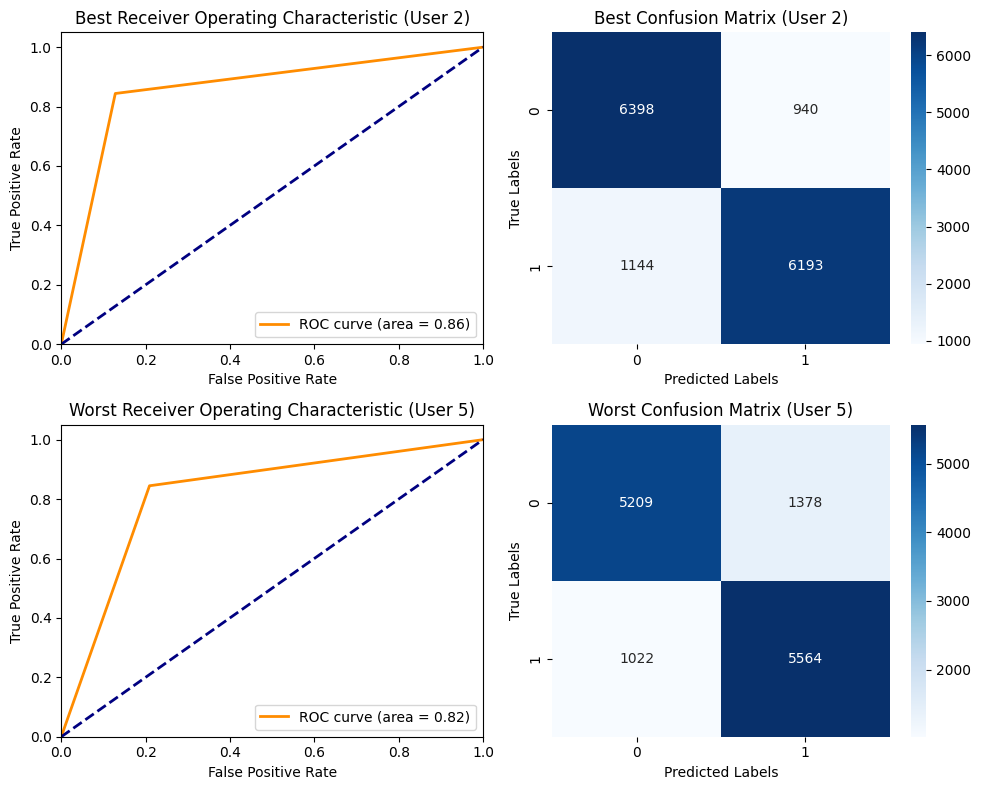

In [6]:
best_roc_auc = 0
worst_roc_auc = 1
mean_roc_auc = 0
cer = []

best_user, worst_user = None, None
best_fpr, best_tpr, worst_fpr, worst_tpr = None, None, None, None
best_cm, worst_cm = None, None

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    predictions = predictions_list[i]

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    cer.append(eer)

    roc_auc = auc(fpr, tpr)
    mean_roc_auc += roc_auc

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_user = i
        best_fpr, best_tpr = fpr, tpr
        best_cm = confusion_matrix(y_test, predictions)

    if roc_auc < worst_roc_auc:
        worst_roc_auc = roc_auc
        worst_user = i
        worst_fpr, worst_tpr = fpr, tpr
        worst_cm = confusion_matrix(y_test, predictions)

mean_roc_auc /= num_classes

print("Mean ROC AUC: ", round(mean_roc_auc, 2))
print('--------------------------------------')
print("Min CER: ", round(min(cer), 2))
print("Max CER: ", round(max(cer), 2))
print("Avg CER: ", round(sum(cer) / len(cer), 2))
print('--------------------------------------')
print("Min F1-score:", round(min(f1_scores), 2))
print("Max F1-score:", round(max(f1_scores), 2))
print("Avg F1-score:", round(sum(f1_scores) / len(f1_scores), 2))
print('--------------------------------------')
print("Min F2-score:", round(min(f2_scores), 2))
print("Max F2-score:", round(max(f2_scores), 2))
print("Avg F2-score:", round(sum(f2_scores) / len(f2_scores), 2))
print('--------------------------------------')
print("Min accuracy:", round(min(accuracy_scores), 2))
print("Max accuracy:", round(max(accuracy_scores), 2))
print("Avg accuracy:", round(sum(accuracy_scores) / len(accuracy_scores), 2))
print('--------------------------------------')
print("Min precision:", round(min(precision_scores), 2))
print("Max precision:", round(max(precision_scores), 2))
print("Avg precision:", round(sum(precision_scores) / len(precision_scores), 2))
print('--------------------------------------')
print("Min recall:", round(min(recall_scores), 2))
print("Max recall:", round(max(recall_scores), 2))
print("Avg recall:", round(sum(recall_scores) / len(recall_scores), 2))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plt.sca(axes[0, 0])
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {best_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Best Receiver Operating Characteristic (User {best_user})')
plt.legend(loc="lower right")

plt.sca(axes[0, 1])
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Best Confusion Matrix (User {best_user})')

plt.sca(axes[1, 0])
plt.plot(worst_fpr, worst_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {worst_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Worst Receiver Operating Characteristic (User {worst_user})')
plt.legend(loc="lower right")

plt.sca(axes[1, 1])
sns.heatmap(worst_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Worst Confusion Matrix (User {worst_user})')

plt.tight_layout()
plt.show()

# **K Nearest Neighbors**

### Hyperparameters tuning

#### Randomized Search

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import random

best_models_random = []

hyperparams = {
        'n_neighbors': list(range(2, 21)), # tested on 2-50 -> best 2
        'leaf_size': list(range(1, 51)),
        'weights': ['uniform', 'distance'],
        'p': [1, 2, 3]
    }

classes = list(range(num_classes))
random.shuffle(classes)
random_classes = classes[:]

for i in random_classes:
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    knn = KNeighborsClassifier()

    random_search = RandomizedSearchCV(knn, hyperparams, cv=5, scoring='accuracy', n_jobs=-1, n_iter=100)
    random_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', random_search.best_params_)
    print('Best score: ', random_search.best_score_)

    best_model = random_search.best_estimator_
    best_models_random.append(best_model)

    predictions = best_model.predict(X_test)

    print(classification_report(y_test, predictions))

User  5
Best hyperparams: {'weights': 'distance', 'p': 1, 'n_neighbors': 2, 'leaf_size': 9}
Best score:  0.7109374554013523
              precision    recall  f1-score   support

           0       0.68      0.84      0.75      6587
           1       0.79      0.61      0.69      6586

    accuracy                           0.73     13173
   macro avg       0.74      0.73      0.72     13173
weighted avg       0.74      0.73      0.72     13173

User  2
Best hyperparams: {'weights': 'distance', 'p': 1, 'n_neighbors': 2, 'leaf_size': 38}
Best score:  0.7047209094802296
              precision    recall  f1-score   support

           0       0.68      0.83      0.74      7337
           1       0.78      0.61      0.68      7338

    accuracy                           0.72     14675
   macro avg       0.73      0.72      0.71     14675
weighted avg       0.73      0.72      0.71     14675

User  6
Best hyperparams: {'weights': 'distance', 'p': 1, 'n_neighbors': 2, 'leaf_size': 23}
Best

#### Grid Search

In [ ]:
best_models_grid = []

hyperparams = {
    'n_neighbors': [2],
    'leaf_size': list(range(1, 31)),
    'weights': ['distance'],
    'p': [1]
}

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    knn = KNeighborsClassifier()

    f1 = make_scorer(f1_score)

    grid_search = GridSearchCV(knn, hyperparams, cv=5, scoring=f1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print('User ', i)
    print('Best hyperparams:', grid_search.best_params_)
    print('Best score: ', grid_search.best_score_)

    best_model = grid_search.best_estimator_
    best_models_grid.append(best_model)

    predictions = best_model.predict(X_test)

    print(classification_report(y_test, predictions))

### Final model

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

hyperparams = {
    'n_neighbors': 2,
    # 'leaf_size': 20, # not used, do not change results
    'weights': 'distance',
    'p': 1 # manhattan distance
}

predictions_list = []
f1_scores = []
f2_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    knn = KNeighborsClassifier(**hyperparams)
    knn.fit(X_train, y_train)

    predictions = knn.predict(X_test)
    predictions_list.append(predictions)

    f1_score = fbeta_score(y_test, predictions, beta=1)
    f2_score = fbeta_score(y_test, predictions, beta=2)
    accuracy = knn.score(X_test, y_test)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    f1_scores.append(f1_score)
    f2_scores.append(f2_score)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    print("User: ", i)
    print(classification_report(y_test, predictions))
    print("F2 score: ", round(f2_score, 2))

User:  0
              precision    recall  f1-score   support

           0       0.70      0.84      0.76      6591
           1       0.80      0.64      0.71      6592

    accuracy                           0.74     13183
   macro avg       0.75      0.74      0.74     13183
weighted avg       0.75      0.74      0.74     13183

F2 score:  0.67
User:  1
              precision    recall  f1-score   support

           0       0.69      0.84      0.76      7938
           1       0.80      0.62      0.69      7938

    accuracy                           0.73     15876
   macro avg       0.74      0.73      0.73     15876
weighted avg       0.74      0.73      0.73     15876

F2 score:  0.65
User:  2
              precision    recall  f1-score   support

           0       0.69      0.83      0.75      7338
           1       0.79      0.62      0.69      7337

    accuracy                           0.73     14675
   macro avg       0.74      0.73      0.72     14675
weighted avg   

Mean ROC AUC:  0.73
--------------------------------------
Min F1-score: 0.69
Max F1-score: 0.72
Avg F1-score: 0.7
--------------------------------------
Min F2-score: 0.64
Max F2-score: 0.68
Avg F2-score: 0.66
--------------------------------------
Min accuracy: 0.72
Max accuracy: 0.75
Avg accuracy: 0.73
--------------------------------------
Min precision: 0.79
Max precision: 0.8
Avg precision: 0.79
--------------------------------------
Min recall: 0.61
Max recall: 0.65
Avg recall: 0.63


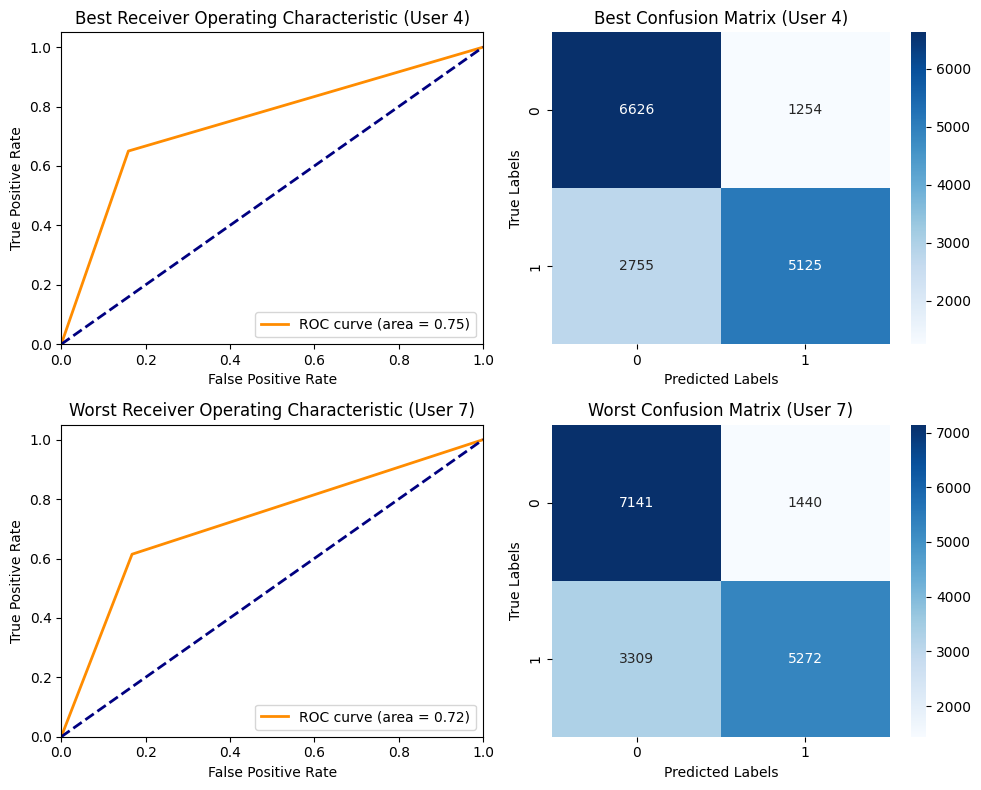

In [8]:
best_roc_auc = 0
worst_roc_auc = 1
mean_roc_auc = 0
cer = []

best_user, worst_user = None, None
best_fpr, best_tpr, worst_fpr, worst_tpr = None, None, None, None
best_cm, worst_cm = None, None

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    predictions = predictions_list[i]

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    cer.append(eer)

    roc_auc = auc(fpr, tpr)
    mean_roc_auc += roc_auc

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_user = i
        best_fpr, best_tpr = fpr, tpr
        best_cm = confusion_matrix(y_test, predictions)

    if roc_auc < worst_roc_auc:
        worst_roc_auc = roc_auc
        worst_user = i
        worst_fpr, worst_tpr = fpr, tpr
        worst_cm = confusion_matrix(y_test, predictions)

mean_roc_auc /= num_classes

print("Mean ROC AUC: ", round(mean_roc_auc, 2))
print('--------------------------------------')
print("Min CER: ", round(min(cer), 2))
print("Max CER: ", round(max(cer), 2))
print("Avg CER: ", round(sum(cer) / len(cer), 2))
print('--------------------------------------')
print("Min F1-score:", round(min(f1_scores), 2))
print("Max F1-score:", round(max(f1_scores), 2))
print("Avg F1-score:", round(sum(f1_scores) / len(f1_scores), 2))
print('--------------------------------------')
print("Min F2-score:", round(min(f2_scores), 2))
print("Max F2-score:", round(max(f2_scores), 2))
print("Avg F2-score:", round(sum(f2_scores) / len(f2_scores), 2))
print('--------------------------------------')
print("Min accuracy:", round(min(accuracy_scores), 2))
print("Max accuracy:", round(max(accuracy_scores), 2))
print("Avg accuracy:", round(sum(accuracy_scores) / len(accuracy_scores), 2))
print('--------------------------------------')
print("Min precision:", round(min(precision_scores), 2))
print("Max precision:", round(max(precision_scores), 2))
print("Avg precision:", round(sum(precision_scores) / len(precision_scores), 2))
print('--------------------------------------')
print("Min recall:", round(min(recall_scores), 2))
print("Max recall:", round(max(recall_scores), 2))
print("Avg recall:", round(sum(recall_scores) / len(recall_scores), 2))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plt.sca(axes[0, 0])
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {best_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Best Receiver Operating Characteristic (User {best_user})')
plt.legend(loc="lower right")

plt.sca(axes[0, 1])
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Best Confusion Matrix (User {best_user})')

plt.sca(axes[1, 0])
plt.plot(worst_fpr, worst_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {worst_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Worst Receiver Operating Characteristic (User {worst_user})')
plt.legend(loc="lower right")

plt.sca(axes[1, 1])
sns.heatmap(worst_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Worst Confusion Matrix (User {worst_user})')

plt.tight_layout()
plt.show()

# **Neural Network**

#### Model

204/204 [==============================] - 0s 459us/step
User: 0, Model Configuration:

{'activations': ['relu', 'relu', 'sigmoid'],
 'batch_size': 1500,
 'dropout': [0.1, 0.1],
 'epochs': 200,
 'layers': [30, 40, 1],
 'learning_rate': 0.001}
              precision    recall  f1-score   support

           0       0.62      0.61      0.62      3263
           1       0.62      0.63      0.62      3263

    accuracy                           0.62      6526
   macro avg       0.62      0.62      0.62      6526
weighted avg       0.62      0.62      0.62      6526

F2 score: 0.62


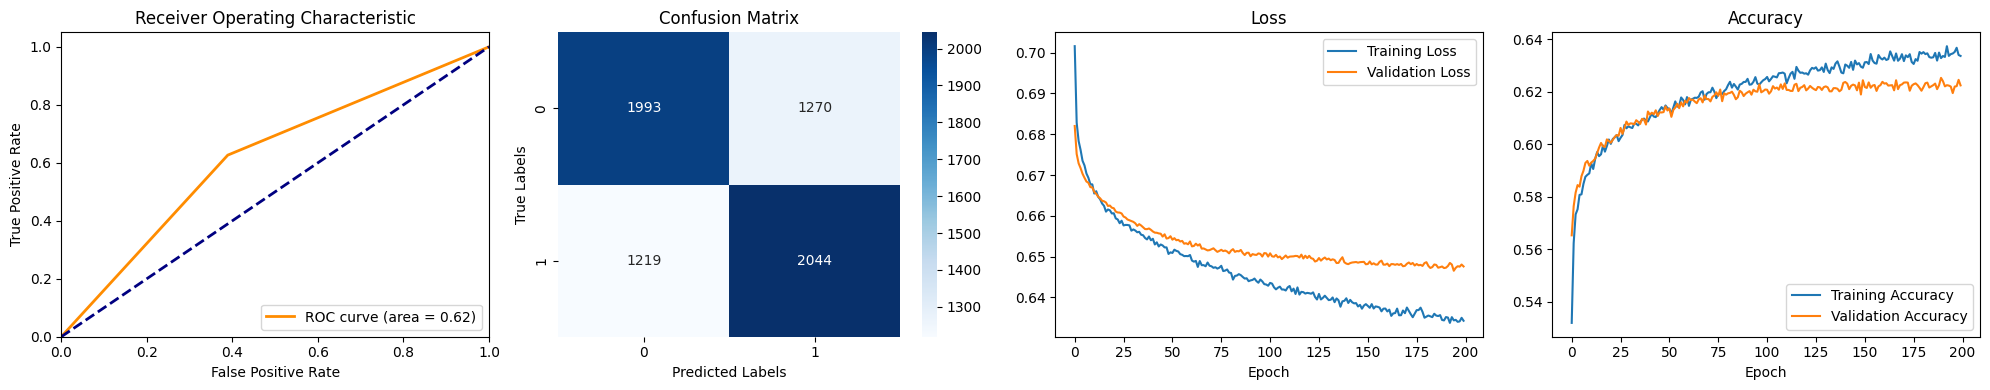

204/204 [==============================] - 0s 502us/step
User: 0, Model Configuration:

{'activations': ['relu', 'relu', 'sigmoid'],
 'batch_size': 1500,
 'dropout': [0.1, 0.1],
 'epochs': 200,
 'layers': [33, 50, 1],
 'learning_rate': 0.001}
              precision    recall  f1-score   support

           0       0.62      0.61      0.62      3263
           1       0.62      0.63      0.62      3263

    accuracy                           0.62      6526
   macro avg       0.62      0.62      0.62      6526
weighted avg       0.62      0.62      0.62      6526

F2 score: 0.63


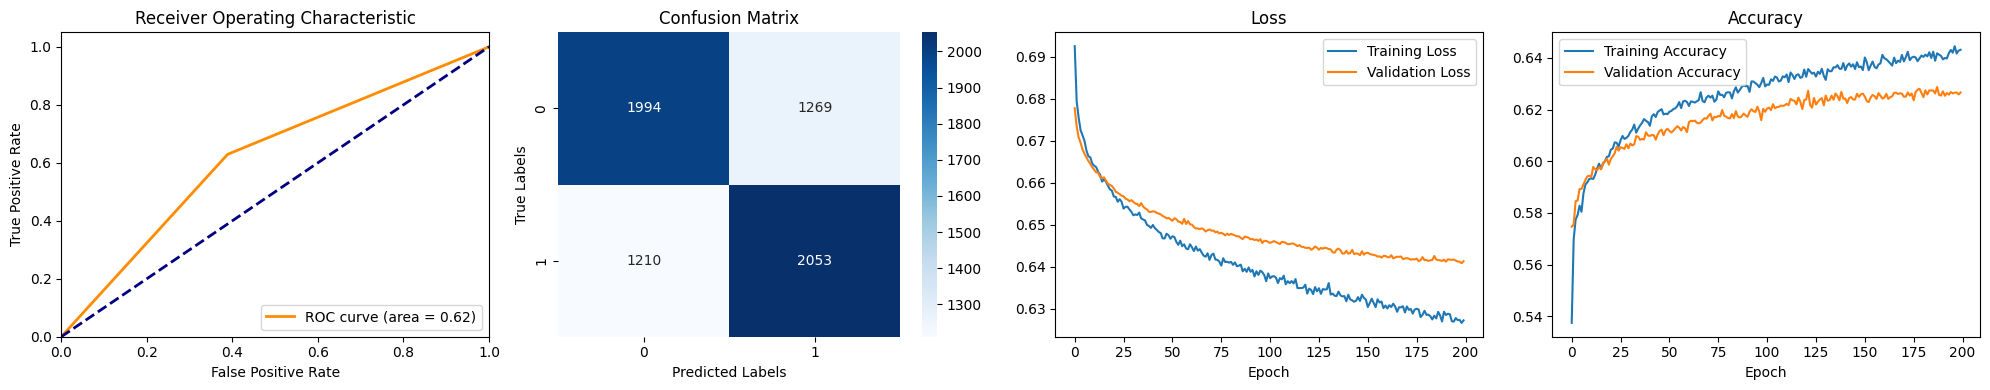

204/204 [==============================] - 0s 459us/step
User: 0, Model Configuration:

{'activations': ['relu', 'relu', 'sigmoid'],
 'batch_size': 1500,
 'dropout': [0.1, 0.1],
 'epochs': 200,
 'layers': [33, 60, 1],
 'learning_rate': 0.001}
              precision    recall  f1-score   support

           0       0.62      0.62      0.62      3263
           1       0.62      0.61      0.61      3263

    accuracy                           0.62      6526
   macro avg       0.62      0.62      0.62      6526
weighted avg       0.62      0.62      0.62      6526

F2 score: 0.61


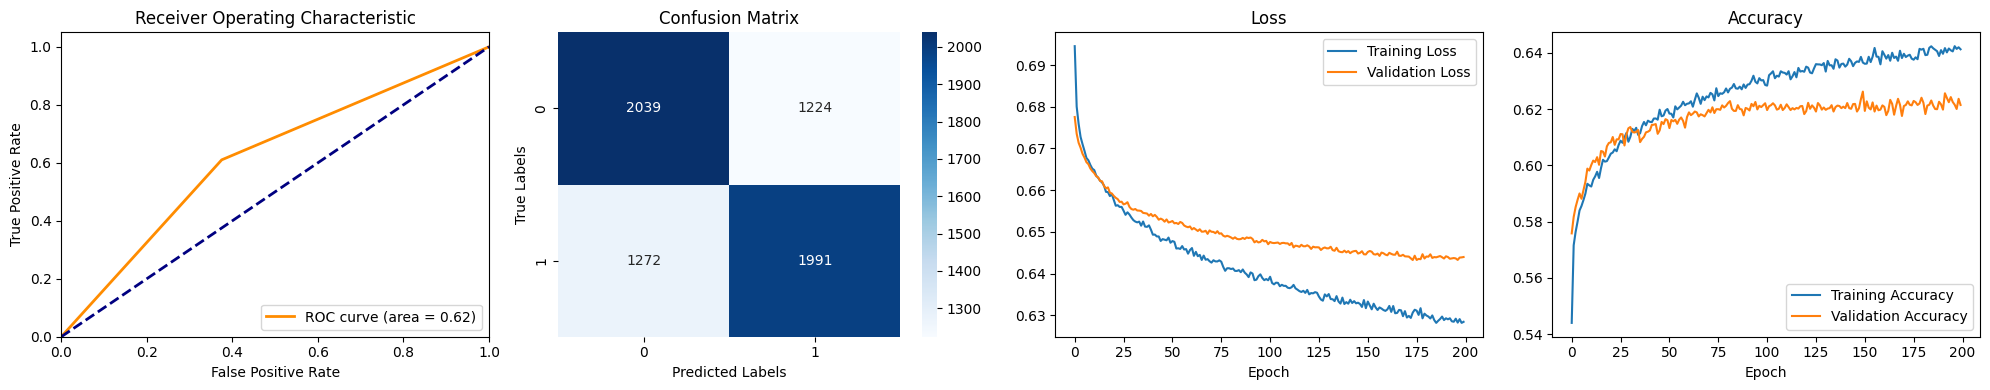

204/204 [==============================] - 0s 452us/step
User: 0, Model Configuration:

{'activations': ['relu', 'relu', 'sigmoid'],
 'batch_size': 1500,
 'dropout': [0.1, 0.1],
 'epochs': 200,
 'layers': [40, 80, 1],
 'learning_rate': 0.001}
              precision    recall  f1-score   support

           0       0.62      0.64      0.63      3263
           1       0.63      0.61      0.62      3263

    accuracy                           0.63      6526
   macro avg       0.63      0.63      0.63      6526
weighted avg       0.63      0.63      0.63      6526

F2 score: 0.62


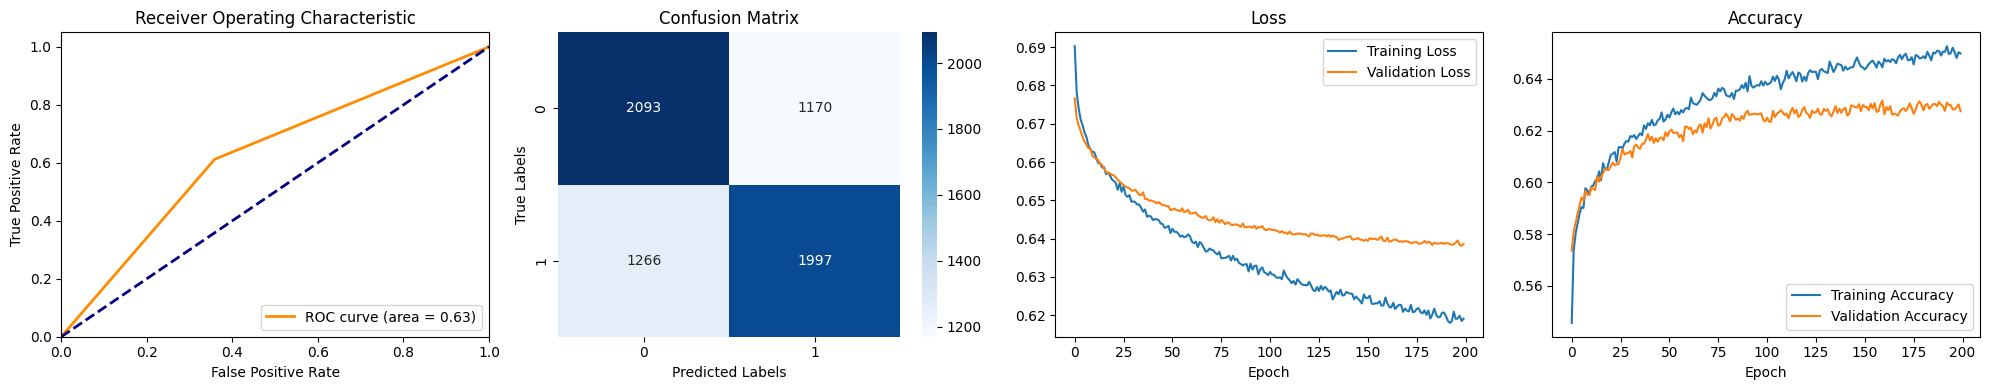

204/204 [==============================] - 0s 491us/step
User: 0, Model Configuration:

{'activations': ['relu', 'relu', 'sigmoid'],
 'batch_size': 1500,
 'dropout': [0.1, 0.1],
 'epochs': 200,
 'layers': [20, 20, 1],
 'learning_rate': 0.001}
              precision    recall  f1-score   support

           0       0.60      0.63      0.62      3263
           1       0.61      0.59      0.60      3263

    accuracy                           0.61      6526
   macro avg       0.61      0.61      0.61      6526
weighted avg       0.61      0.61      0.61      6526

F2 score: 0.59


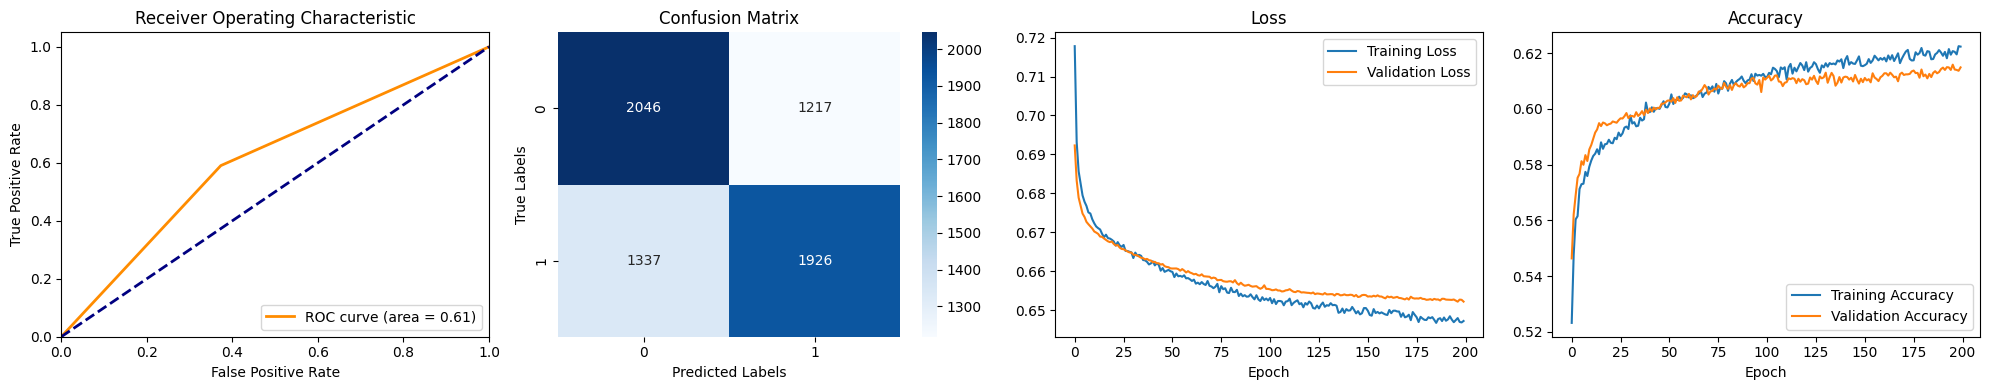

204/204 [==============================] - 0s 451us/step
User: 0, Model Configuration:

{'activations': ['relu', 'relu', 'sigmoid'],
 'batch_size': 1500,
 'dropout': [0.2, 0.2],
 'epochs': 200,
 'layers': [80, 80, 1],
 'learning_rate': 0.001}
              precision    recall  f1-score   support

           0       0.63      0.64      0.64      3263
           1       0.64      0.63      0.63      3263

    accuracy                           0.63      6526
   macro avg       0.63      0.63      0.63      6526
weighted avg       0.63      0.63      0.63      6526

F2 score: 0.63


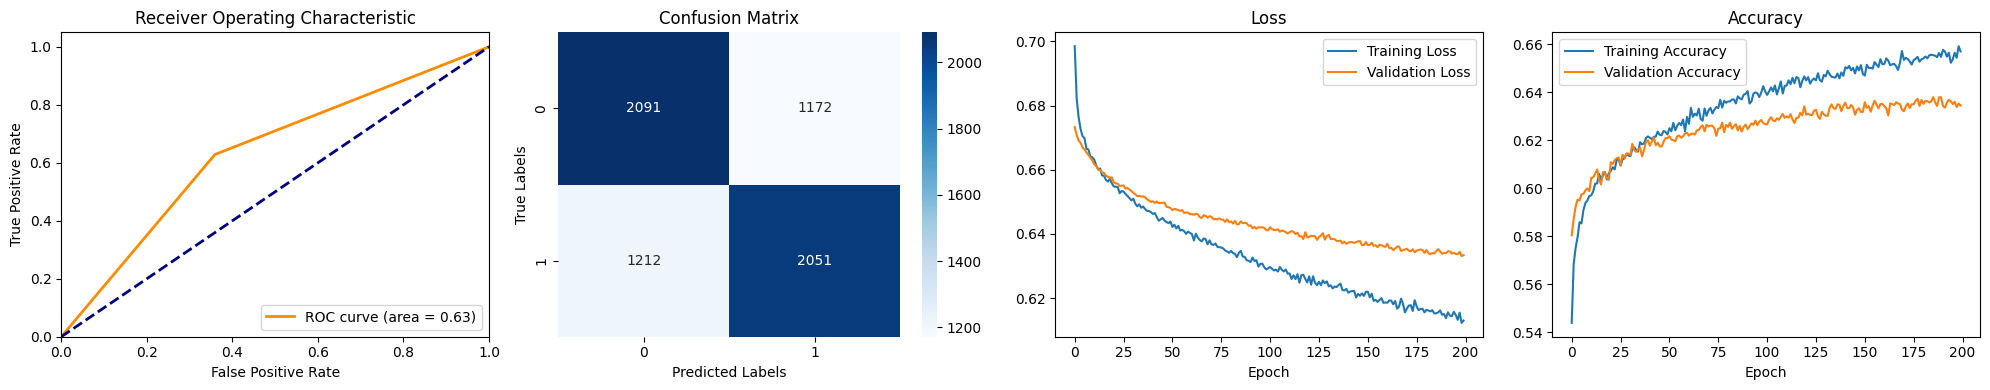

204/204 [==============================] - 0s 467us/step
User: 0, Model Configuration:

{'activations': ['relu', 'relu', 'relu', 'sigmoid'],
 'batch_size': 1500,
 'dropout': [0.1, 0.1, 0.1],
 'epochs': 200,
 'layers': [20, 30, 50, 1],
 'learning_rate': 0.001}
              precision    recall  f1-score   support

           0       0.60      0.64      0.62      3263
           1       0.62      0.58      0.60      3263

    accuracy                           0.61      6526
   macro avg       0.61      0.61      0.61      6526
weighted avg       0.61      0.61      0.61      6526

F2 score: 0.59


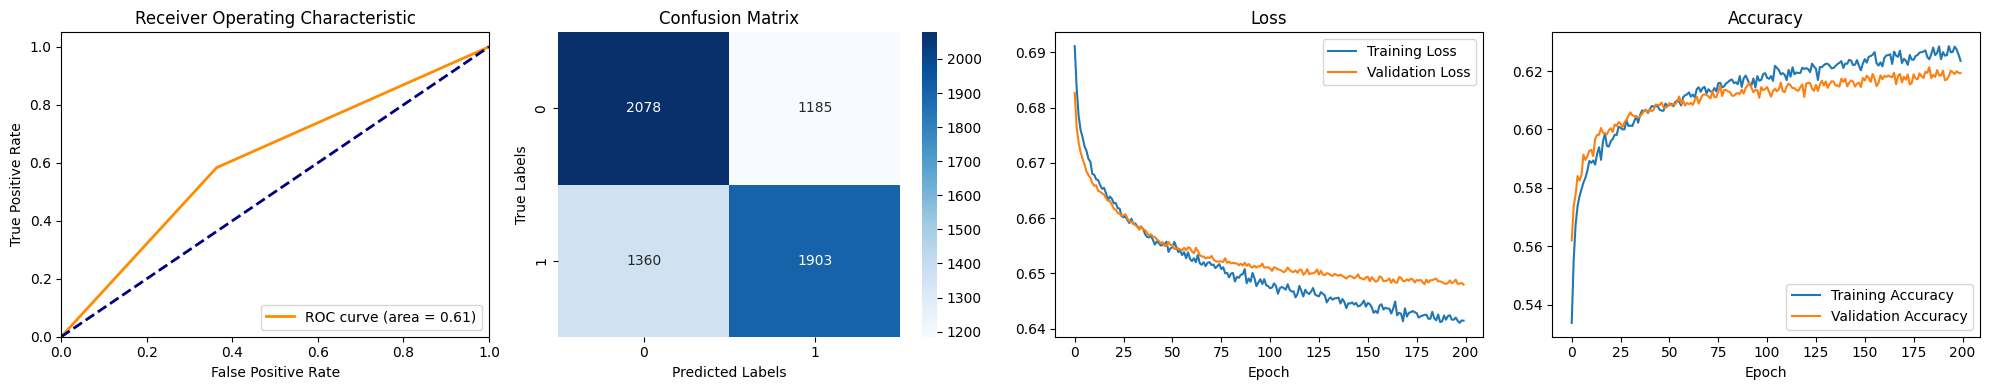

204/204 [==============================] - 0s 513us/step
User: 0, Model Configuration:

{'activations': ['relu', 'relu', 'relu', 'sigmoid'],
 'batch_size': 1500,
 'dropout': [0.1, 0.1, 0.1],
 'epochs': 200,
 'layers': [20, 30, 20, 1],
 'learning_rate': 0.001}
              precision    recall  f1-score   support

           0       0.60      0.65      0.62      3263
           1       0.62      0.57      0.59      3263

    accuracy                           0.61      6526
   macro avg       0.61      0.61      0.61      6526
weighted avg       0.61      0.61      0.61      6526

F2 score: 0.58


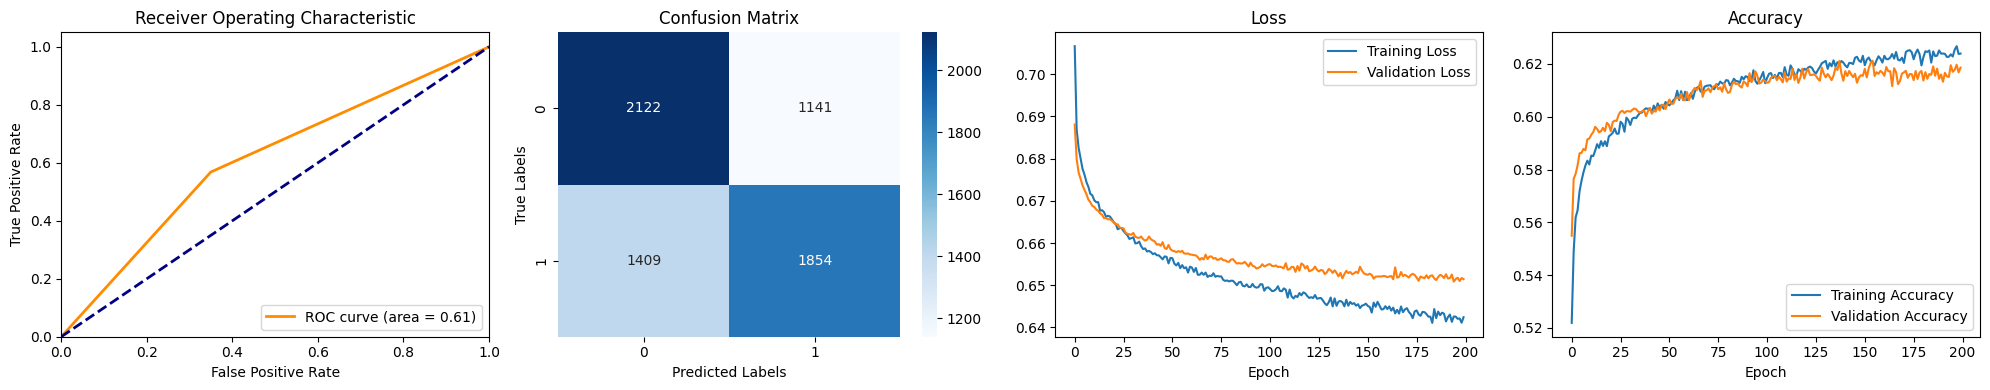

In [5]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

predictions_list = []
history_list = []
f1_scores = []
f2_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

X_train_list = []
X_test_list_nn = []
y_train_list = []
y_test_list_nn = []

# scale data to the same size for neural network
# min_length = min(len(user[i]) for i in range(num_classes))

# define different model configs
model_configurations = [
    # {
    #     'layers': [33, 200, 200, 200, 1],
    #     'dropout': [0.3, 0.4, 0.4, 0.4],
    #     'epochs': 250,
    #     'activations': ['relu', 'relu', 'sigmoid', 'sigmoid', 'sigmoid'],
    #     'batch_size': 1500,
    #     'learning_rate': 0.001
    # },
    # {
    #     'layers': [33, 100, 100, 1],
    #     'dropout': [0.2, 0.4, 0.4],
    #     'epochs': 300,
    #     'activations': ['relu', 'relu', 'sigmoid', 'sigmoid'],
    #     'batch_size': 1500,
    #     'learning_rate': 0.001
    # },
    # {
    #     'layers': [33, 300, 300, 1],
    #     'dropout': [0.2, 0.5, 0.5],
    #     'epochs': 200,
    #     'activations': ['relu', 'relu', 'relu', 'sigmoid'],
    #     'batch_size': 1500,
    #     'learning_rate': 0.001
    # },

    ### NEW ###
    {
        'layers': [30, 40, 1], # 40 a bit better than 30 in 2nd layer
        'dropout': [0.1, 0.1],
        'epochs': 200,
        'activations': ['relu', 'relu', 'sigmoid'],
        'batch_size': 1500,
        'learning_rate': 0.001
    },
    {
        'layers': [33, 50, 1],
        'dropout': [0.1, 0.1],
        'epochs': 200,
        'activations': ['relu', 'relu', 'sigmoid'],
        'batch_size': 1500,
        'learning_rate': 0.001
    },
    {
        'layers': [33, 60, 1],
        'dropout': [0.1, 0.1],
        'epochs': 200,
        'activations': ['relu', 'relu', 'sigmoid'],
        'batch_size': 1500,
        'learning_rate': 0.001
    },
    {
        'layers': [40, 80, 1],
        'dropout': [0.1, 0.1],
        'epochs': 200,
        'activations': ['relu', 'relu', 'sigmoid'],
        'batch_size': 1500,
        'learning_rate': 0.001
    },
    {
        'layers': [20, 20, 1],
        'dropout': [0.1, 0.1],
        'epochs': 200,
        'activations': ['relu', 'relu', 'sigmoid'],
        'batch_size': 1500,
        'learning_rate': 0.001
    },
    {
        'layers': [80, 80, 1],
        'dropout': [0.2, 0.2],
        'epochs': 200,
        'activations': ['relu', 'relu', 'sigmoid'],
        'batch_size': 1500,
        'learning_rate': 0.001
    },
    {
        'layers': [20, 30, 50, 1],
        'dropout': [0.1, 0.1, 0.1],
        'epochs': 200,
        'activations': ['relu', 'relu', 'relu', 'sigmoid'],
        'batch_size': 1500,
        'learning_rate': 0.001
    },
    {
        'layers': [20, 30, 20, 1],
        'dropout': [0.1, 0.1, 0.1],
        'epochs': 200,
        'activations': ['relu', 'relu', 'relu', 'sigmoid'],
        'batch_size': 1500,
        'learning_rate': 0.001
    },
]

import random
from pprint import pprint
classes = list(range(num_classes))
random.shuffle(classes)
random_classes = classes[-1:]

for i in range(1): #random_classes: #range(num_classes):
    # user[i] = user[i].sample(n=min_length)
    # impostor[i] = impostor[i].sample(n=min_length)
    merged_data = pd.concat([user[i], impostor[i]])

    X = merged_data.loc[:, 'mean_x_speed':'numCritPoints']
    y = merged_data['class']

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp)

    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    X_train_list.append(X_train)
    X_test_list_nn.append(X_test)
    y_train_list.append(y_train)
    y_test_list_nn.append(y_test)

    for j, config in enumerate(model_configurations):
        model = Sequential()
        for k in range(len(config['layers'])):
            activation = config['activations'][k] if k < len(config['activations']) else 'sigmoid'
            if k == 0:
                model.add(Dense(config['layers'][k], input_dim=33, activation=activation))
            else:
                model.add(Dense(config['layers'][k], activation=activation))
            if k < len(config['dropout']):
                model.add(Dropout(config['dropout'][k]))

        adam = Adam(learning_rate=config['learning_rate'])
        model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=config['batch_size'], epochs=config['epochs'], verbose=0)
        history_list.append(history)

        predictions = model.predict(X_test)
        predictions = (predictions > 0.5).astype(int)
        predictions_list.append(predictions)

        f1_score = fbeta_score(y_test, predictions, beta=1)
        f2_score = fbeta_score(y_test, predictions, beta=2)
        accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)

        print(f"User: {i}, Model Configuration:\n")
        pprint(model_configurations[j])
        print(classification_report(y_test, predictions))
        print(f"F2 score: {round(f2_score, 2)}")

        #############################################################################
        fig, axes = plt.subplots(1, 4, figsize=(20, 4))

        fpr, tpr, thresholds = roc_curve(y_test, predictions_list[j])
        roc_auc = auc(fpr, tpr)
        cm = confusion_matrix(y_test, predictions_list[j])

        plt.sca(axes[0])
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic')
        plt.legend(loc="lower right")

        plt.sca(axes[1])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix')

        plt.sca(axes[2])
        plt.plot(history_list[j].history['loss'], label='Training Loss')
        plt.plot(history_list[j].history['val_loss'], label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.legend()

        plt.sca(axes[3])
        plt.plot(history_list[j].history['accuracy'], label='Training Accuracy')
        plt.plot(history_list[j].history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()

        plt.tight_layout()
        plt.show()

#### Diagrams

In [ ]:
best_roc_auc = 0
worst_roc_auc = 1
mean_roc_auc = 0
cer = []

best_user, worst_user = None, None
best_fpr, best_tpr, worst_fpr, worst_tpr = None, None, None, None
best_cm, worst_cm = None, None
best_history, worst_history = None, None

for i in range(num_classes):
    X_train = X_train_list[i]
    X_test = X_test_list_nn[i]
    y_train = y_train_list[i]
    y_test_ = y_test_list_nn[i]

    predictions = predictions_list[i]
    history = history_list[i]

    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)

    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    cer.append(eer)

    mean_roc_auc += roc_auc

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_user = i
        best_fpr, best_tpr = fpr, tpr
        best_cm = confusion_matrix(y_test, predictions)
        best_history = history

    if roc_auc < worst_roc_auc:
        worst_roc_auc = roc_auc
        worst_user = i
        worst_fpr, worst_tpr = fpr, tpr
        worst_cm = confusion_matrix(y_test, predictions)
        worst_history = history

mean_roc_auc /= num_classes

print()
print('--------------------------------------')
print("Mean ROC AUC: ", round(mean_roc_auc, 2))
print('--------------------------------------')
print("Min CER: ", round(min(cer), 2))
print("Max CER: ", round(max(cer), 2))
print("Avg CER: ", round(sum(cer) / len(cer), 2))
print('--------------------------------------')
print("Min F1-score:", round(min(f1_scores), 2))
print("Max F1-score:", round(max(f1_scores), 2))
print("Avg F1-score:", round(sum(f1_scores) / len(f1_scores), 2))
print('--------------------------------------')
print("Min F2-score:", round(min(f2_scores), 2))
print("Max F2-score:", round(max(f2_scores), 2))
print("Avg F2-score:", round(sum(f2_scores) / len(f2_scores), 2))
print('--------------------------------------')
print("Min accuracy:", round(min(accuracy_scores), 2))
print("Max accuracy:", round(max(accuracy_scores), 2))
print("Avg accuracy:", round(sum(accuracy_scores) / len(accuracy_scores), 2))
print('--------------------------------------')
print("Min precision:", round(min(precision_scores), 2))
print("Max precision:", round(max(precision_scores), 2))
print("Avg precision:", round(sum(precision_scores) / len(precision_scores), 2))
print('--------------------------------------')
print("Min recall:", round(min(recall_scores), 2))
print("Max recall:", round(max(recall_scores), 2))
print("Avg recall:", round(sum(recall_scores) / len(recall_scores), 2))

fig, axes = plt.subplots(2, 4, figsize=(20, 8))

plt.sca(axes[0, 0])
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {best_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Best Receiver Operating Characteristic (User {best_user})')
plt.legend(loc="lower right")

plt.sca(axes[0, 1])
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Best Confusion Matrix (User {best_user})')

plt.sca(axes[0, 2])
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.sca(axes[0, 3])
plt.plot(best_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.sca(axes[1, 0])
plt.plot(worst_fpr, worst_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {worst_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Worst Receiver Operating Characteristic (User {worst_user})')
plt.legend(loc="lower right")

plt.sca(axes[1, 1])
sns.heatmap(worst_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Worst Confusion Matrix (User {worst_user})')

plt.sca(axes[1, 2])
plt.plot(worst_history.history['loss'], label='Training Loss')
plt.plot(worst_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.sca(axes[1, 3])
plt.plot(worst_history.history['accuracy'], label='Training Accuracy')
plt.plot(worst_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# **Clustering**

## TSNE - t-Distributed Stochastic Neighbor Embedding

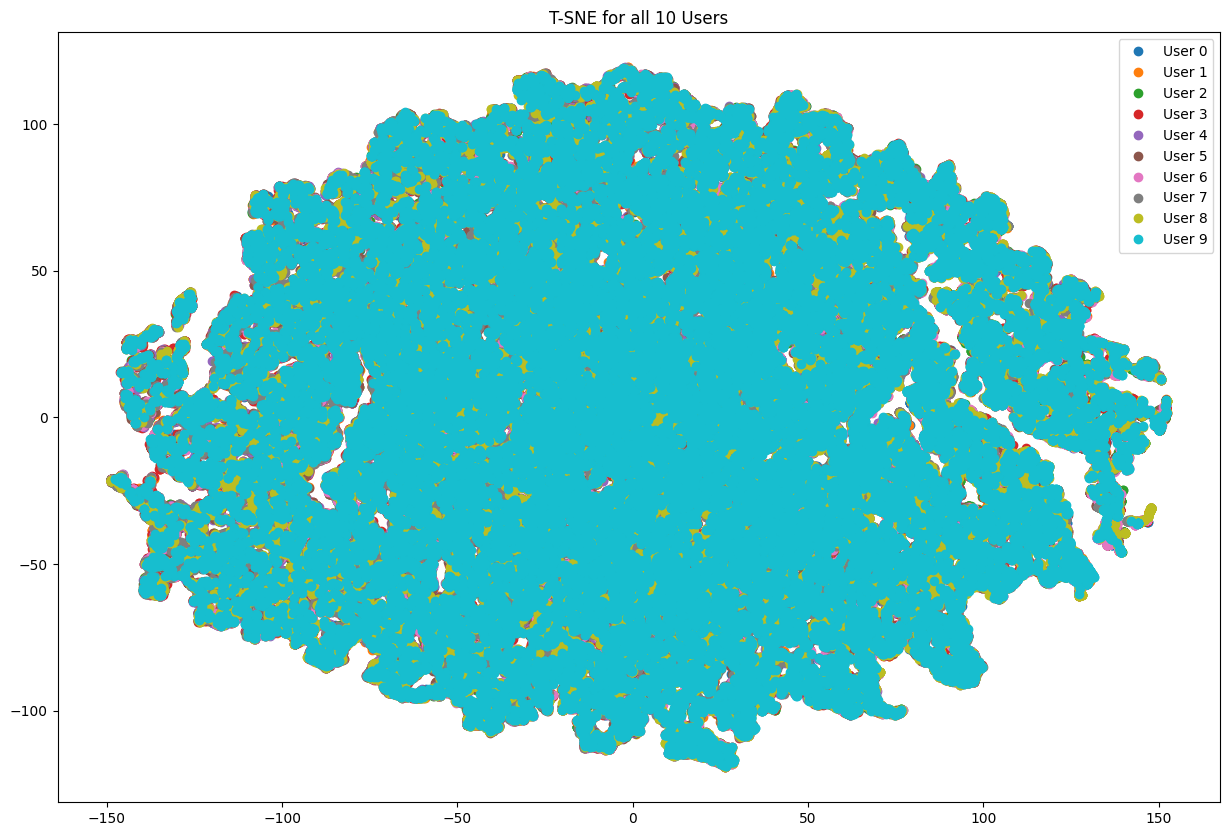

In [7]:
from sklearn.manifold import TSNE

y = dataset['class'].values
X = dataset.drop(columns=['class'])

classes = np.unique(y)

tsne = TSNE(perplexity=50, metric='manhattan')
X_reduced = tsne.fit_transform(X)

plt.figure(figsize=(15, 10))
for y_ in classes:
    data = X_reduced[y == y_]
    plt.plot(data[:, 0], data[:, 1], 'o', label='User {}'.format(y_))

plt.title('T-SNE for all 10 Users')
plt.legend()

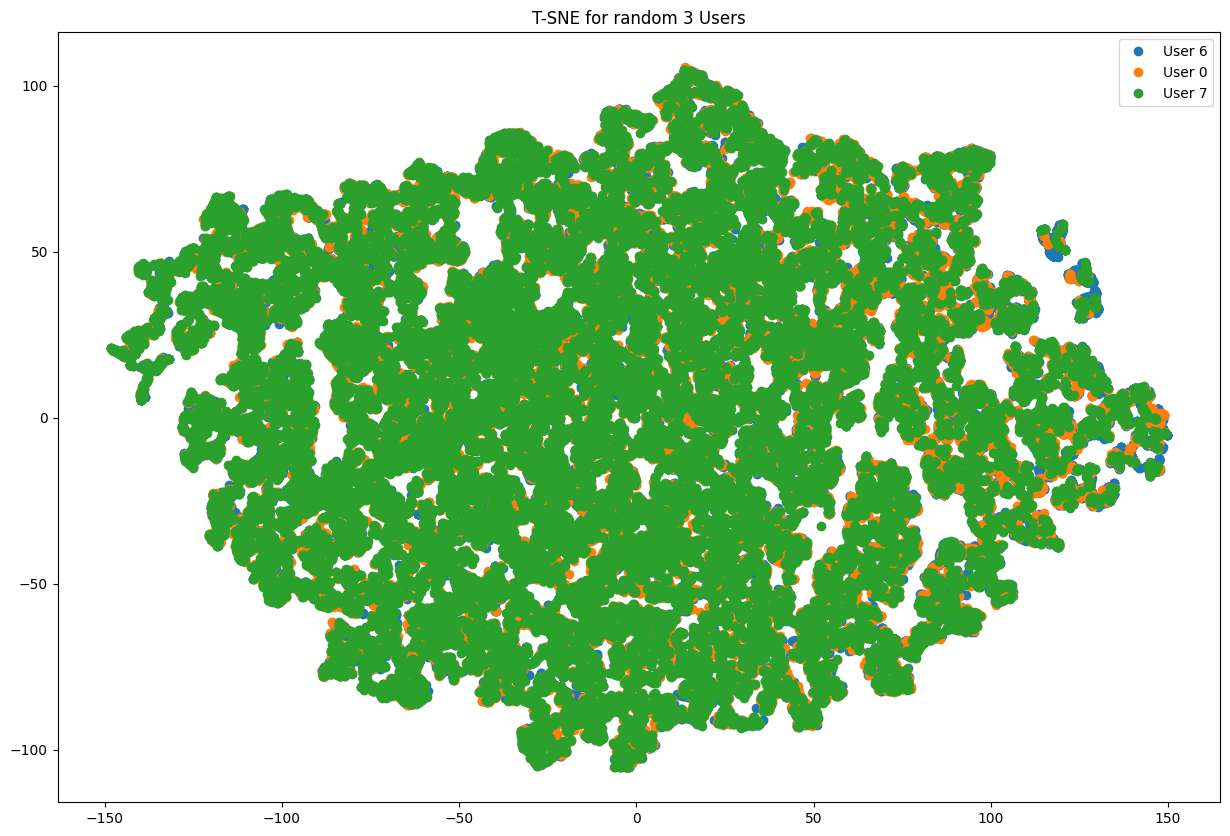

In [8]:
import random

y = dataset['class'].values
X = dataset.drop(columns=['class'])

# pick random 10 classes 
classes = np.unique(y)
random.shuffle(classes)
classes = classes[:3]

# map randomly chosen classes - True/False and select proper X rows
chosen = []
for y_ in y:
    if y_ in classes:
        chosen.append(True)
    else:
        chosen.append(False)

X = X.values[chosen]
y = y[chosen]

tsne = TSNE(perplexity=50, metric='manhattan')
X_reduced = tsne.fit_transform(X)

plt.figure(figsize=(15, 10))
for y_ in classes:
    data = X_reduced[y == y_]
    plt.plot(data[:, 0], data[:, 1], 'o', label='User {}'.format(y_))

plt.title('T-SNE for random 3 Users')
plt.legend()

## K-Means

### Elbow Method

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

X = dataset.drop(columns=['class'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sse = [] # Sum of Squared Errors - distance between each point and centroid in the cluster - evaluation metric
silhouette = []
davies_bouldin = []

k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto')
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)  # inertia - Sum of Squared Errors
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))
    davies_bouldin.append(davies_bouldin_score(X_scaled, kmeans.labels_))

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

axes[0].plot(k_range, sse, marker='o')
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('SSE')
axes[0].set_title('Elbow Method for optimal k - SSE')

axes[1].plot(k_range, silhouette, marker='o')
axes[1].set_xlabel('Number of clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score for optimal k')

axes[2].plot(k_range, davies_bouldin, marker='o')
axes[2].set_xlabel('Number of clusters')
axes[2].set_ylabel('Davies-Bouldin Score')
axes[2].set_title('Davies-Bouldin Score for optimal k')

plt.tight_layout()
plt.show()

print('SSEs: ', sse)
print('Silhouette Scores: ', silhouette)
print('Davies-Bouldin Scores: ', davies_bouldin)

### Evaluation

Percentage of variance using 2D PCA: 45.75%


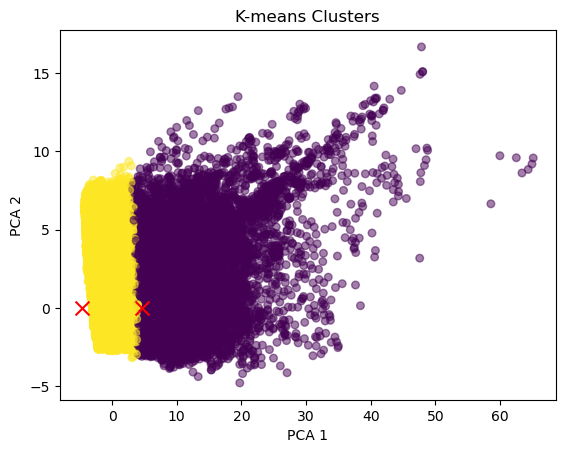

In [101]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = dataset.drop(columns=['class'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)
x = X_2d[:, 0]
y = X_2d[:, 1]

print('Percentage of variance using 2D PCA: {:.2f}%'.format(np.sum(pca.explained_variance_ratio_ * 100)))

k_values = [4, 5]

fig = plt.figure(figsize=(15, 6))

for i, k in enumerate(k_values):    
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto')
    kmeans.fit(X_scaled)

    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    # map centroids using PCA
    centroids_2d = pca.fit_transform(centroids)
    
    plt.subplot(1, 2, i + 1)
    plt.scatter(x, y, c=kmeans.labels_, alpha=0.3, s=30)
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], marker='x', s=100, color='red')
    plt.title('K-means Clusters for k={}'.format(k))
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')

plt.subplots_adjust(wspace=0.3)
plt.show()

### 2 random users evaluation

Percentage of variance using 2D PCA: 46.07%


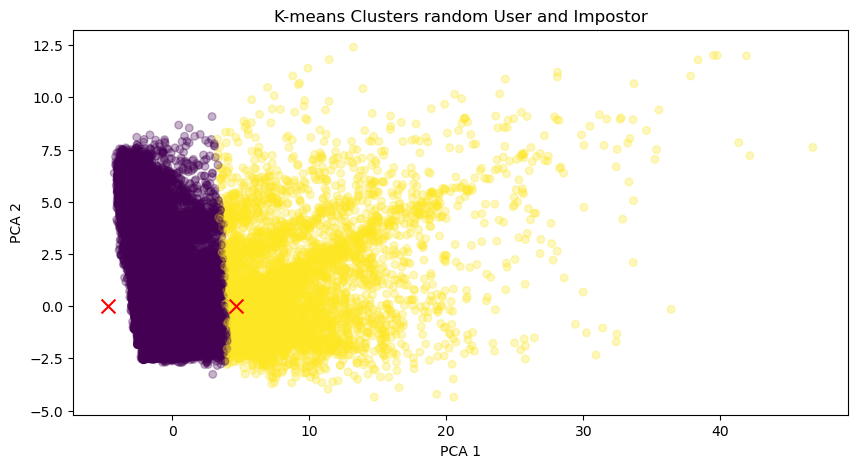

Adjusted Mutual Information Score:  1.0


In [111]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_mutual_info_score

# pick random 
i = random.choice(range(10))
random_user = user[i]
random_impostor = impostor[i]

X = pd.concat([user[i], impostor[i]])
labels = X['class'].values
X = X.drop(columns=['class'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)
x = X_2d[:, 0]
y = X_2d[:, 1]

print('Percentage of variance using 2D PCA: {:.2f}%'.format(np.sum(pca.explained_variance_ratio_ * 100)))

k = 2

kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto')
kmeans.fit(X_scaled)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# map centroids using PCA
centroids_2d = pca.fit_transform(centroids)

fig = plt.figure(figsize=(10, 5))
plt.scatter(x, y, c=kmeans.labels_, alpha=0.3, s=30)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], marker='x', s=100, color='red')
plt.title('K-means Clusters random User and Impostor')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

ami = adjusted_mutual_info_score(labels, kmeans.labels_)
print('Adjusted Mutual Information Score: ', ami)